In [113]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda')
device

device(type='cuda')

<h3>Creating the model</h3>

In [3]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=6, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

        )
        
        self.fc_layers = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),  # Acts like a linear layer
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=15, kernel_size=1)    # Output size of 15
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  
        x = self.conv_layers(x)
        #print(x.shape)
        x = self.fc_layers(x)
        x = self.flatten(x)
        is_digit = x[:,0]
        coordinates = x[:,[1,2,3,4]]
        digit = x[:,5:]
        return is_digit,coordinates,digit

<h4>Path to data</h4>

In [5]:
directory = 'D://DigitDetectionDataset'
num_files = len([name for name in os.listdir(directory)])

In [6]:
num_files

1000

In [7]:
def return_data(path):
    data = pd.read_csv(path)
    data = data.sample(len(data) - 1).values  

    digit = data[:, 0].astype(int)  
    is_digit = (digit != -1).astype(float)
    #print(is_digit)
    one_hot_digit = np.zeros((len(data), 10), dtype=np.float32)  
    # Fill one-hot encoding
    for i in range(len(data)):
        if is_digit[i] == 1:  # Check if the sample is a digit
            one_hot_digit[i][digit[i]] = 1

    is_digit_tensor = torch.FloatTensor(is_digit).to(device)  
    one_hot_digit_tensor = torch.FloatTensor(one_hot_digit).to(device)  
    coordinates = torch.FloatTensor(data[:, [1, 2, 3, 4]]).to(device) / 128  
    images = torch.FloatTensor(data[:, 5:].reshape((len(data), 128,128, 3))).to(device)

    return is_digit_tensor, one_hot_digit_tensor, coordinates, images

In [8]:
model = CustomCNN()
model = model.to(device)

In [9]:
# Define the loss functions
bce_loss = nn.BCEWithLogitsLoss()
mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()

In [10]:
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001) 

<h4>Training loop</h4>

In [ ]:
def train(epochs):
    model.train()
    for e in range(epochs):
        print("Epoch : ", e)
        file_counter = 0
        epoch_loss = 0
        dirs = os.listdir(directory)
        np.random.shuffle(dirs)
        for file in dirs:
            filename = os.fsdecode(file)
            if filename.endswith(".csv"):
                file_counter += 1
                true_is_digit, true_one_hot_digit, true_coordinates, images = return_data(directory + "//" + filename)
                images = images.to(device)  # Move to GPU if using one
                true_is_digit = true_is_digit.to(device).float()
                true_one_hot_digit = true_one_hot_digit.to(device)
                true_coordinates = true_coordinates.to(device).float()
            else:
                continue

            # Forward pass
            pred_is_digit, pred_coordinates, pred_digit = model(images)
            
            loss_is_digit = bce_loss(pred_is_digit, true_is_digit)
            loss_coordinates = mse_loss(pred_coordinates[true_is_digit == 1], true_coordinates[true_is_digit == 1])
            loss_digit = ce_loss(pred_digit[true_is_digit == 1], true_one_hot_digit.argmax(dim=1)[true_is_digit == 1])

            total_loss = loss_is_digit + loss_coordinates + loss_digit
            if file_counter % 20 == 0:
                print("File: ", "[" , file_counter , "/" , num_files , "]", " total loss: ",round(total_loss.item(),5),"  is digit loss: " , round(loss_is_digit.item(),5) ,  
                      " coordinates loss: " , round(loss_coordinates.item(),5), " classification loss: " , round(loss_digit.item(),5))

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
            
            if file_counter % 20 == 0:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, "DigitDetectionModel_epoch" + str(e) + ".pth")                
            
                print(f'Model saved after processing {file_counter} files in epoch {e}.')

        print(f"Total Loss for Epoch {e}: {epoch_loss}")

In [ ]:
train(15)

<h3>Displaying some results of the model</h3>

In [12]:
def display_images(X, y=None, amount=30,figsize=(16,16),rows=4,cols=5):
    rows = rows
    columns = cols
    fig, axs = plt.subplots(rows, columns, figsize=figsize, gridspec_kw={'wspace': 0.02, 'hspace': 0.2})

    for i in range(columns * rows):
        img = X[i]
        ax = axs[i // columns, i % columns]  # Get the correct subplot
        ax.imshow(img)
        if y is not None:
            ax.set_title(y[i], fontsize=14)  # Set the title with the label
        ax.axis('off')  # Hide the axes
    plt.show()

In [13]:
model = CustomCNN().to(device)
checkpoint = torch.load("DigitDetectionModel_epoch8.pth",weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

CustomCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(6, 6), stride=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (fc_layers): Sequential(
    (0): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Dropo

<h3>Checking the results on a random training sample</h3>

In [14]:
path = 'D://DigitDetectionDataset//92.csv'
is_digit,one_hot_digit,coordinates,images = return_data(path)

In [15]:
test_images = []
test_labels = []
for k in range(50):
    with torch.no_grad():
        pred_is_digit, pred_coordinates, pred_digit = model(images[k].unsqueeze(0))
    coordinates = (pred_coordinates.detach().cpu().numpy()*128).astype(int).flatten()

    im = images[k].detach().cpu().numpy()

    if pred_is_digit[0] < 0.7:
        test_images.append(im)
        test_labels.append("no digit")
        continue
        
    bounded = im.copy()
    coordinates = np.clip(coordinates,0,128)
    br = coordinates[0]
    bc = coordinates[1]
    w = coordinates[2]
    h = coordinates[3]
    bounded[br,bc] = 0
    mh = h//2
    mw = w//2
    for i in range(br-mh,br+mh,1):
        try:
            #print(i,bc-mw)
            bounded[i,bc-mw-1:bc-mw+1] = 0
            bounded[i,bc+mw-1:bc+mw+1] = 0
        except:
            pass
    for i in range(bc-mw,bc+mw,1):
        try:
            bounded[br-mh-1:br-mh+1,i] = 0
            bounded[br+mh-1:br+mh+1,i] = 0
        except:
            pass    
    test_images.append(bounded)
    test_labels.append("digit " + str(pred_digit.argmax().item()))


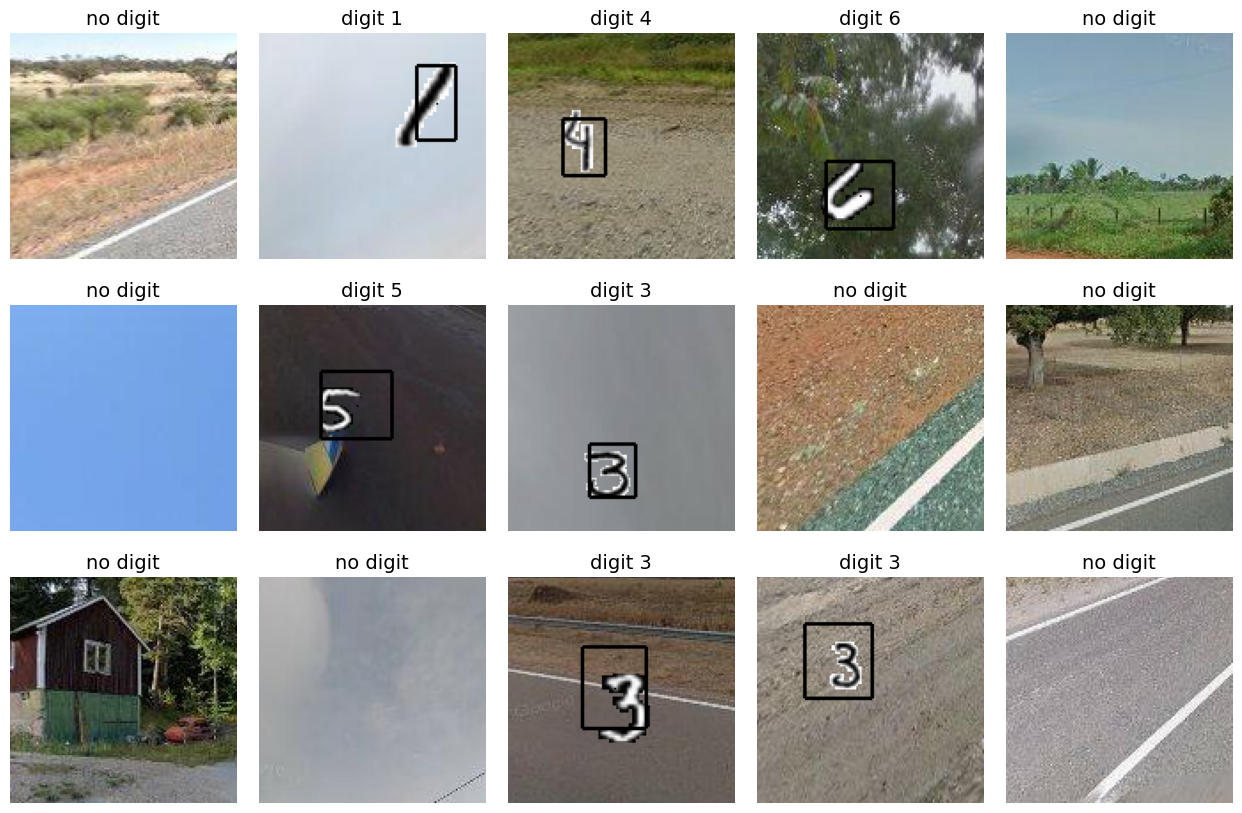

In [16]:
display_images(test_images[:],test_labels[:],amount=15,figsize=(16,10),rows=3,cols=5)

<h3>Now we write a sliding windows algorithm and check the model's performance on this test image</h3>

In [17]:
im = plt.imread("test_img.png")[:,:,:3]
im = im.reshape((600,600,3))

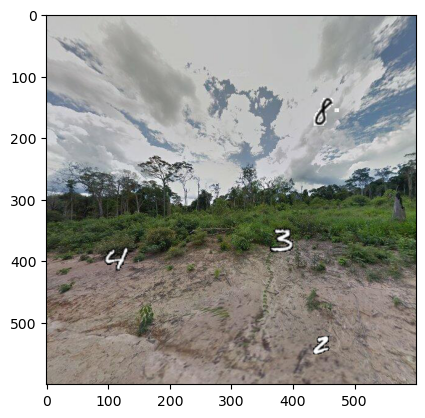

In [18]:
plt.imshow(im)
plt.show()

In [19]:
stride = 600/128
num_windows = int((600-128)/stride)

<h3>Sliding Windows</h3>

In [102]:
# Initialize an empty list to store the images for each iteration
frames = []
boxes = []
red = np.array([1, 0, 0])

# Original loop setup
original_bounded = im.reshape((600, 600, 3)).copy()
jump = 5
for row in range(0, num_windows, jump):
    for col in range(0, num_windows, jump):
        curr_window_row = int(row * stride)
        curr_window_col = int(col * stride)
        curr_window = im[curr_window_row:curr_window_row + 128, curr_window_col:curr_window_col + 128, :].copy()
        model_input = np.expand_dims(curr_window, axis=0)
        model_input = torch.FloatTensor(model_input).to(device)

        with torch.no_grad():
            pred_is_digit, pred_coordinates, pred_digit = model(model_input)

        coordinates = (pred_coordinates.detach().cpu().numpy() * 128).astype(int).flatten()
        pred_is_digit = torch.sigmoid(pred_is_digit)[0].detach().cpu().numpy()
        pred_digit = torch.softmax(pred_digit, dim=1).detach().cpu().numpy()
        digit = pred_digit[0].argmax()
        conviction = pred_digit[0].max()

        bounded = im.copy()
        coordinates = np.clip(coordinates, 0, 127)
        
        #Only recognize images whos bounding box is centered and the model is certain that it is a digit
        if pred_is_digit > 0.99995 and (coordinates[0] > 28 and coordinates[0] < 100) and (coordinates[1] > 28 and coordinates[1] < 100):
            br = coordinates[0] + curr_window_row
            bc = coordinates[1] + curr_window_col
            w = coordinates[2]
            h = coordinates[3]
            boxes.append(np.array([br,bc,w,h,digit,conviction,pred_is_digit]))
            try:
                bounded[br, bc] = 0
                original_bounded[br, bc] = 0
            except:
                pass
            mh = h // 2
            mw = w // 2
            
            
            for i in range(br - mh, br + mh, 1):
                try:
                    bounded[i, bc - mw - 1:bc - mw + 1] = red
                    bounded[i, bc + mw - 1:bc + mw + 1] = red
                    original_bounded[i, bc - mw - 1:bc - mw + 1] = red
                    original_bounded[i, bc + mw - 1:bc + mw + 1] = red
                except:
                    pass
            for i in range(bc - mw, bc + mw, 1):
                try:
                    bounded[br - mh - 1:br - mh + 1, i] = red
                    bounded[br + mh - 1:br + mh + 1, i] = red
                    original_bounded[br - mh - 1:br - mh + 1, i] = red
                    original_bounded[br + mh - 1:br + mh + 1, i] = red
                except:
                    pass

        section = im.copy()
        section[curr_window_row:curr_window_row + 128, curr_window_col:curr_window_col + 128, :] = np.array([1, 0, 0])

        # Append the current trio of images (section, bounded, original_bounded) as a frame
        fig, axs = plt.subplots(1, 3, figsize=(20, 10))  # Increase figure size
        
        axs[0].imshow(section)
        axs[0].set_title("Current Window", fontsize=16)  # Set larger title font size
        axs[0].axis('off')
        
        axs[1].imshow(bounded)
        axs[1].set_title("Match", fontsize=16)  # Set larger title font size
        axs[1].axis('off')

        axs[2].imshow(original_bounded)
        axs[2].set_title("All Matches", fontsize=16)  # Set larger title font size
        axs[2].axis('off')

        # Convert the figure to an image and append it to frames
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(image)

        plt.close(fig)  # Close the figure to avoid display during each iteration

C:\Users\skche\AppData\Local\Temp\ipykernel_16108\1410920535.py:81: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


<h3>Saving the animation</h3>

In [103]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [104]:
import cv2
def create_video(frames, output_path, fps=20):
    height, width = frames[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for frame in frames:
        if frame.ndim == 3 and frame.shape[2] == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame)
    
    out.release()

In [105]:
create_video(frames, 'output.mp4', fps=15)

<h3>Using Non-Maximum Suppresion to remove all overlaping boxes and keep only the main ones</h3>

In [106]:
def intersection_area(box1, box2):
    br1, bc1, w1, h1 = box1[:4]
    br2, bc2, w2, h2 = box2[:4]

    left1, right1 = bc1 - w1 // 2, bc1 + w1 // 2
    top1, bottom1 = br1 - h1 // 2, br1 + h1 // 2

    left2, right2 = bc2 - w2 // 2, bc2 + w2 // 2
    top2, bottom2 = br2 - h2 // 2, br2 + h2 // 2

    overlap_width = max(0, min(right1, right2) - max(left1, left2))
    overlap_height = max(0, min(bottom1, bottom2) - max(top1, top2))

    return overlap_width * overlap_height


In [107]:
def union_area(box1, box2):
    area1 = box1[2] * box1[3]
    area2 = box2[2] * box2[3]

    intersect_area = intersection_area(box1, box2)

    return area1 + area2 - intersect_area

In [108]:
def iou(box1, box2):
    intersect_area = intersection_area(box1, box2)
    union_area_value = union_area(box1, box2)
    if union_area_value == 0:
        return 0  
    iou_value = intersect_area / union_area_value
    
    return iou_value

In [109]:
def filter_boxes(boxes):
    filtered_boxes = []
    used_indices = set()

    while len(boxes) > 0:

        available_indices = [i for i in range(len(boxes)) if i not in used_indices]
        
        if not available_indices:
            break  

        best_index = max(
            available_indices,
            key=lambda i: boxes[i][6]  # Conviction value
        )
        best_box = boxes[best_index]
        filtered_boxes.append(best_box)
        used_indices.add(best_index)
        boxes = [
            box for i, box in enumerate(boxes)
            if i not in used_indices and iou(best_box, box) <= 0.05
        ]

    return filtered_boxes

<h3>Filtering the boxes and drawing the final result</h3>

In [130]:
filtered_boxes = filter_boxes(boxes)
len(filtered_boxes)

4

In [133]:
final_image = im.copy()
red = np.array([1, 0, 0])
for box in filtered_boxes:
    curr_box = box.astype(int)
    br = curr_box[0]
    bc = curr_box[1]
    w = curr_box[2]
    h = curr_box[3]
    digit = curr_box[4]
    conviction = curr_box[5]

    try:
        final_image[br, bc] = 0
    except:
        pass

    mh = h // 2
    mw = w // 2
    
    for i in range(br - mh, br + mh, 1):
        try:
            final_image[i, bc - mw - 1:bc - mw + 1] = red
            final_image[i, bc + mw - 1:bc + mw + 1] = red
        except:
            pass
    
    for i in range(bc - mw, bc + mw, 1):
        try:
            final_image[br - mh - 1:br - mh + 1, i] = red
            final_image[br + mh - 1:br + mh + 1, i] = red
        except:
            pass

    text = f"Digit: {digit}"
    text_position = (bc - mw - 10, br - mh - 5)  

    cv2.putText(final_image, text, text_position, 
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=0.7,  
                color=(1, 0, 0),  
                thickness=2)  

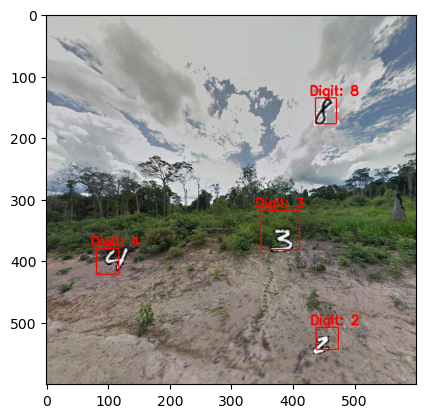

In [134]:
plt.imshow(final_image)
plt.show()